<a href="https://colab.research.google.com/github/amoniaka-knabino/sirius_climate_2024/blob/main/FINAL_RESULTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

column_name = ['year', 'mon', 'day', 'hour', 'lat', 'lon', 'hsun', 'slp', 'ta', 'sst', 'td', 'rh', 'icn', 'icl', 'low', 'mid', 'high', 'iww', 'ws', 'wd']
numbers = range(1, 13)
years_first_decade = range(1950, 1961)
years_second_decade = range(1961, 1963)

In [ ]:
df_first_decade = pd.DataFrame()
df_second_decade = pd.DataFrame()

#### В данной работе используется коллекция данных DISO3 (Dataset of In-Situ Observations over the Ocean, коллекция данных in situ наблюдений в море).

Эта коллекция данных унаследована от набора данных ICO 1] (International Comprehensive Ocean-Atmosphere Data Set) - набора данных попутных визуальных наблюдений и измерений. ICOADS содержит данные о морской поверхности и сопутствующие метеорологические наблюдения и измерения за период с 1662 года по настоящее время, а также простые сводные продукты в виде сеточных месячных массивов с разрешением сетки 2° по широте и 2° по долготе, начиная с 1800 года (и для ячеек размером 1°x1° с 1960 года). Эти данные и продукты распространяются свободно. Поскольку ICOADS содержит наблюдения из множества различных систем наблюдений, охватывающих развитие технологий измерения на протяжении сотен лет, ICOADS, вероятно, является самой полной гетерогенной коллекцией данных о морской поверхности, существующей в настоящее время.

DISO3 - подмножество данных ICOADS, прошедшее тщательную фильтрацию и чистку, коррекцию значений характеристик облачности в ранние периоды наблюдений и в период смены и унификации стандартов, а также содержащее дополнительные расчетные переменные относительной влажности атмосферы (rh) над океаном и локальной высоты солнца (hsun) в точке наблюдения.

Данные коллекции DISO3 покрывают период с 1880г. по 2017г. Данные записаны в форме таблицы с фиксированным размером колонок, без специально обозначенных разделителей. Спецификация колонок и назначение переменных описано в таблице ниже.

In [ ]:
for year in years_first_decade:
  for n in [str(num).zfill(2) for num in numbers]:
    df_next_file = pd.read_fwf(f"{year}_{n}_data.fwf", names=column_name)
    df_first_decade = pd.concat([df_first_decade, df_next_file], axis=0)

#### Отфильтруем по координатам область, соответствующую Северной Атлантике

In [ ]:
df_first_decade_atlantic = df_first_decade[
            (df_first_decade["lat"] > 20) &
            (df_first_decade["lat"] < 60) &
            (df_first_decade["lon"] <-10) &
            (df_first_decade["lon"] >-50)]
df_first_decade_atlantic

,year,mon,day,hour,lat,lon,hsun,slp,ta,sst,td,rh,icn,icl,low,mid,high,iww,ws,wd
3,1950,1,1,0,59.9,-19.9,-49.36,994.7,7.8,9.4,1.6,0.648,2,-9,-9,-9,-9,-99,17.8,214.0
4,1950,1,1,0,58.7,-16.0,-51.39,1005.2,8.9,9.4,6.7,0.861,7,5,5,7,0,0,15.4,210.0
5,1950,1,1,0,58.2,-21.0,-50.48,1000.6,7.8,7.8,5.6,0.860,4,4,8,0,0,0,15.4,225.0
6,1950,1,1,0,55.0,-13.4,-55.34,1019.0,11.1,10.0,11.1,1.000,8,8,5,-9,-9,0,15.4,203.0
8,1950,1,1,0,54.4,-15.6,-55.29,1014.8,11.1,11.1,10.1,0.936,7,7,5,0,0,8,-9.9,-9.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109301,1960,12,1,0,47.2,-32.8,-25.87,1016.3,14.2,12.0,10.3,0.774,8,-9,-9,-9,-9,-99,19.0,230.0
109305,1960,12,1,0,44.8,-15.8,-37.63,1025.0,10.0,11.1,6.7,0.799,5,5,9,0,0,2,13.4,295.0
109307,1960,12,1,0,44.0,-41.0,-19.61,1016.4,16.7,16.1,15.0,0.897,8,8,5,10,10,60,15.9,180.0
109321,1960,12,1,0,35.0,-48.0,-11.73,1017.2,20.0,21.1,18.3,0.900,8,5,7,2,10,21,2.1,205.0


In [ ]:
for year in years_second_decade:
  for n in [str(num).zfill(2) for num in numbers]:
    df_next_file = pd.read_fwf(f"{year}_{n}_data.fwf", names=column_name)
    df_second_decade = pd.concat([df_second_decade, df_next_file], axis=0)

In [ ]:
df_second_decade_atlantic = df_second_decade[
            (df_second_decade["lat"] > 20) &
            (df_second_decade["lat"] < 60) &
            (df_second_decade["lon"] <-10) &
            (df_second_decade["lon"] >-50)]
df_second_decade_atlantic

,year,mon,day,hour,lat,lon,hsun,slp,ta,sst,td,rh,icn,icl,low,mid,high,iww,ws,wd
2,1961,1,1,0,58.7,-17.8,-50.94,988.5,7.9,9.7,4.7,0.802,2,2,2,0,0,1,11.8,280.0
11,1961,1,1,0,55.7,-30.7,-48.80,989.9,6.7,9.4,3.9,0.823,8,8,7,-9,-9,25,15.4,250.0
24,1961,1,1,0,53.4,-15.9,-56.07,1002.0,7.8,10.7,6.3,0.902,8,3,2,1,-9,15,14.4,270.0
25,1961,1,1,0,53.2,-17.3,-55.80,1004.4,7.2,-99.9,4.4,0.824,7,3,7,2,0,2,15.4,290.0
27,1961,1,1,0,53.0,-36.0,-47.91,1003.6,5.6,6.1,0.0,0.672,8,8,-9,-9,-9,-99,13.4,270.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109180,1962,12,1,0,44.7,-15.9,-37.56,1006.2,9.4,12.8,2.3,0.612,2,2,2,0,0,2,6.2,295.0
109181,1962,12,1,0,44.0,-41.0,-19.61,1010.7,13.9,14.4,8.9,0.718,1,1,1,0,0,2,4.6,115.0
109191,1962,12,1,0,38.4,-11.2,-41.34,1011.2,13.6,15.2,11.7,0.883,8,6,3,2,-9,60,5.1,250.0
109194,1962,12,1,0,35.0,-48.0,-11.73,998.2,20.0,20.0,16.7,0.813,8,8,8,10,10,80,10.3,225.0


#### Проведём предварительную обработку данных:
1) В тех столбцах, где отсутствующим ячейкам были присвоены определённые значения, заменим их на NaN

In [ ]:
names_for_drop = ['icn', 'icl', 'low', 'mid', 'high', 'iww', 'ws', 'wd']
values_for_drop = [-9, -9, -9, -9, -9, -99, -9.9, -9.9]

df_first_decade_replaced = df_first_decade_atlantic
df_second_decade_replaced = df_second_decade_atlantic

for key, value in zip(names_for_drop, values_for_drop):
  df_first_decade_replaced.loc[:, key] = df_first_decade_replaced[key].replace(value, np.nan)

for key, value in zip(names_for_drop, values_for_drop):
    df_second_decade_replaced.loc[:, key] = df_second_decade_replaced[key].replace(value, np.nan)

2) Преобразуем столбцы, соответствующие дате и времени, в гармонические функции и удалим их

In [ ]:
from copy import copy

def get_day_number(month, day):
    return 31*(month-1)+day

def code_cyclic_values(df, cyclic_columns):
    new_df = copy(df)
    new_df.drop(cyclic_columns, axis=1, inplace=True)
    for c in cyclic_columns:
        max_v = df[c].max()
        new_df[f'{c}_sin'] = np.sin(2 * np.pi * df[c]/max_v)
        new_df[f'{c}_cos'] = np.cos(2 * np.pi * df[c]/max_v)
    return new_df

filtered_encoded_train = copy(df_first_decade_replaced)

filtered_encoded_train["day_number"] = get_day_number(filtered_encoded_train["mon"], filtered_encoded_train["day"])
filtered_encoded_train.drop(["day", "mon"], axis=1, inplace=True)

filtered_encoded_train = code_cyclic_values(filtered_encoded_train, ["lon", "day_number", "hour", "wd"])
filtered_encoded_train

,year,lat,hsun,slp,ta,sst,td,rh,icn,icl,...,iww,ws,lon_sin,lon_cos,day_number_sin,day_number_cos,hour_sin,hour_cos,wd_sin,wd_cos
3,1950,59.9,-49.36,994.7,7.8,9.4,1.6,0.648,2.0,NaN,...,NaN,17.8,-0.100063,0.994981,0.017951,0.999839,0.0,1.0,-0.541968,-0.840399
4,1950,58.7,-51.39,1005.2,8.9,9.4,6.7,0.861,7.0,5.0,...,0.0,15.4,-0.563197,-0.826323,0.017951,0.999839,0.0,1.0,-0.482362,-0.875972
5,1950,58.2,-50.48,1000.6,7.8,7.8,5.6,0.860,4.0,4.0,...,0.0,15.4,0.555407,0.831578,0.017951,0.999839,0.0,1.0,-0.691600,-0.722281
6,1950,55.0,-55.34,1019.0,11.1,10.0,11.1,1.000,8.0,8.0,...,0.0,15.4,0.857552,-0.514397,0.017951,0.999839,0.0,1.0,-0.372639,-0.927976
8,1950,54.4,-55.29,1014.8,11.1,11.1,10.1,0.936,7.0,7.0,...,8.0,NaN,-0.340712,-0.940168,0.017951,0.999839,0.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109301,1960,47.2,-25.87,1016.3,14.2,12.0,10.3,0.774,8.0,NaN,...,NaN,19.0,0.991965,-0.126514,-0.143122,0.989705,0.0,1.0,-0.751601,-0.659618
109305,1960,44.8,-37.63,1025.0,10.0,11.1,6.7,0.799,5.0,5.0,...,2.0,13.4,-0.455525,-0.890223,-0.143122,0.989705,0.0,1.0,-0.917961,0.396670
109307,1960,44.0,-19.61,1016.4,16.7,16.1,15.0,0.897,8.0,8.0,...,60.0,15.9,0.523767,0.851862,-0.143122,0.989705,0.0,1.0,0.017356,-0.999849
109321,1960,35.0,-11.73,1017.2,20.0,21.1,18.3,0.900,8.0,5.0,...,21.0,2.1,-0.975027,0.222085,-0.143122,0.989705,0.0,1.0,-0.404621,-0.914484


In [ ]:
filtered_encoded_test = copy(df_second_decade_replaced)

filtered_encoded_test["day_number"] = get_day_number(filtered_encoded_test["mon"], filtered_encoded_test["day"])
filtered_encoded_test.drop(["day", "mon"], axis=1, inplace=True)

filtered_encoded_test = code_cyclic_values(filtered_encoded_test, ["lon", "day_number", "hour", "wd"])
filtered_encoded_test

,year,lat,hsun,slp,ta,sst,td,rh,icn,icl,...,iww,ws,lon_sin,lon_cos,day_number_sin,day_number_cos,hour_sin,hour_cos,wd_sin,wd_cos
2,1961,58.7,-50.94,988.5,7.9,9.7,4.7,0.802,2.0,2.0,...,1.0,11.8,-0.996978,0.077684,0.017951,0.999839,0.0,1.0,-0.989137,0.146999
11,1961,55.7,-48.80,989.9,6.7,9.4,3.9,0.823,8.0,8.0,...,25.0,15.4,0.246279,0.969199,0.017951,0.999839,0.0,1.0,-0.931175,-0.364572
24,1961,53.4,-56.07,1002.0,7.8,10.7,6.3,0.902,8.0,3.0,...,15.0,14.4,-0.449828,-0.893115,0.017951,0.999839,0.0,1.0,-0.999661,-0.026032
25,1961,53.2,-55.80,1004.4,7.2,-99.9,4.4,0.824,7.0,3.0,...,2.0,15.4,-0.972912,-0.231176,0.017951,0.999839,0.0,1.0,-0.948888,0.315612
27,1961,53.0,-47.91,1003.6,5.6,6.1,0.0,0.672,8.0,8.0,...,NaN,13.4,-0.393434,-0.919353,0.017951,0.999839,0.0,1.0,-0.999661,-0.026032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109180,1962,44.7,-37.56,1006.2,9.4,12.8,2.3,0.612,2.0,2.0,...,2.0,6.2,-0.449828,-0.893115,-0.143122,0.989705,0.0,1.0,-0.917961,0.396670
109181,1962,44.0,-19.61,1010.7,13.9,14.4,8.9,0.718,1.0,1.0,...,2.0,4.6,0.364652,0.931144,-0.143122,0.989705,0.0,1.0,0.910938,-0.412542
109191,1962,38.4,-41.34,1011.2,13.6,15.2,11.7,0.883,8.0,6.0,...,60.0,5.1,0.632136,0.774857,-0.143122,0.989705,0.0,1.0,-0.931175,-0.364572
109194,1962,35.0,-11.73,998.2,20.0,20.0,16.7,0.813,8.0,8.0,...,80.0,10.3,-0.999879,0.015552,-0.143122,0.989705,0.0,1.0,-0.691600,-0.722281


In [ ]:
df_first_decade_replaced = filtered_encoded_train.dropna()
df_second_decade_replaced = filtered_encoded_test.dropna()

#### Модель Северной Атлантики общая

Разбиение на тренировочный и тестовый набор происходит следующим образом образом:
<br>Тренировочный - с 1950 по 1960 год
<br>Тестовый - с 1961 по 1962 год

In [ ]:
y_train = df_first_decade_replaced['rh']

x_train = df_first_decade_replaced.drop(['td', 'rh'], axis=1, inplace=False)

In [ ]:
y_test = df_second_decade_replaced['rh']

x_test = df_second_decade_replaced.drop(['td', 'rh'], axis=1, inplace=False)

In [ ]:
x_test = x_test.drop('year', axis=1, inplace=False)
x_train = x_train.drop('year', axis=1, inplace=False)

#### Линейная регрессия

In [ ]:
model = LinearRegression().fit(x_train, y_train)

y_pred = model.predict(x_test)

R_2 = r2_score(y_test, y_pred)
RMSE = root_mean_squared_error(y_test, y_pred)

print('R**2 score:', R_2)
print('RMSE:', RMSE)

R**2 score: 0.1560015173689483
RMSE: 0.10294914031496981


#### Алгоритм градиентног бустинга CatBoost

In [ ]:
from catboost import CatBoostRegressor, Pool

In [ ]:
cat_features = ['iww', 'low', 'mid', 'high']

for value in cat_features:
    x_train[value] = x_train[value].astype(str)
    x_test[value] = x_test[value].astype(str)

In [ ]:
model_cat = CatBoostRegressor(iterations=100,
                          depth=2,
                          learning_rate=1,
                          loss_function='RMSE')

train_pool = Pool(x_train, y_train, cat_features=['iww', 'low', 'mid', 'high'])
test_pool = Pool(x_test, y_test, cat_features=['iww', 'low', 'mid', 'high'])

model_cat.fit(train_pool)
y_pred_cat = model_cat.predict(test_pool)

R_2_catboost = r2_score(y_test, y_pred_cat)
RMSE_catboost = root_mean_squared_error(y_test, y_pred_cat)

print('R**2 catboost score:', R_2_catboost)
print('RMSE catboost:', RMSE_catboost)

0:	learn: 0.1046179	total: 381ms	remaining: 37.7s
1:	learn: 0.1025442	total: 624ms	remaining: 30.6s
2:	learn: 0.1014245	total: 775ms	remaining: 25.1s
3:	learn: 0.0997748	total: 971ms	remaining: 23.3s
4:	learn: 0.0992704	total: 1.1s	remaining: 20.8s
5:	learn: 0.0989889	total: 1.22s	remaining: 19.1s
6:	learn: 0.0988174	total: 1.4s	remaining: 18.6s
7:	learn: 0.0985913	total: 1.55s	remaining: 17.8s
8:	learn: 0.0984430	total: 1.68s	remaining: 17s
9:	learn: 0.0983389	total: 1.82s	remaining: 16.4s
10:	learn: 0.0981250	total: 1.96s	remaining: 15.9s
11:	learn: 0.0980247	total: 2.11s	remaining: 15.5s
12:	learn: 0.0978830	total: 2.25s	remaining: 15.1s
13:	learn: 0.0977691	total: 2.39s	remaining: 14.7s
14:	learn: 0.0976810	total: 2.5s	remaining: 14.2s
15:	learn: 0.0975751	total: 2.62s	remaining: 13.7s
16:	learn: 0.0975021	total: 2.73s	remaining: 13.3s
17:	learn: 0.0973136	total: 2.84s	remaining: 12.9s
18:	learn: 0.0971313	total: 2.96s	remaining: 12.6s
19:	learn: 0.0970065	total: 3.08s	remaining: 1

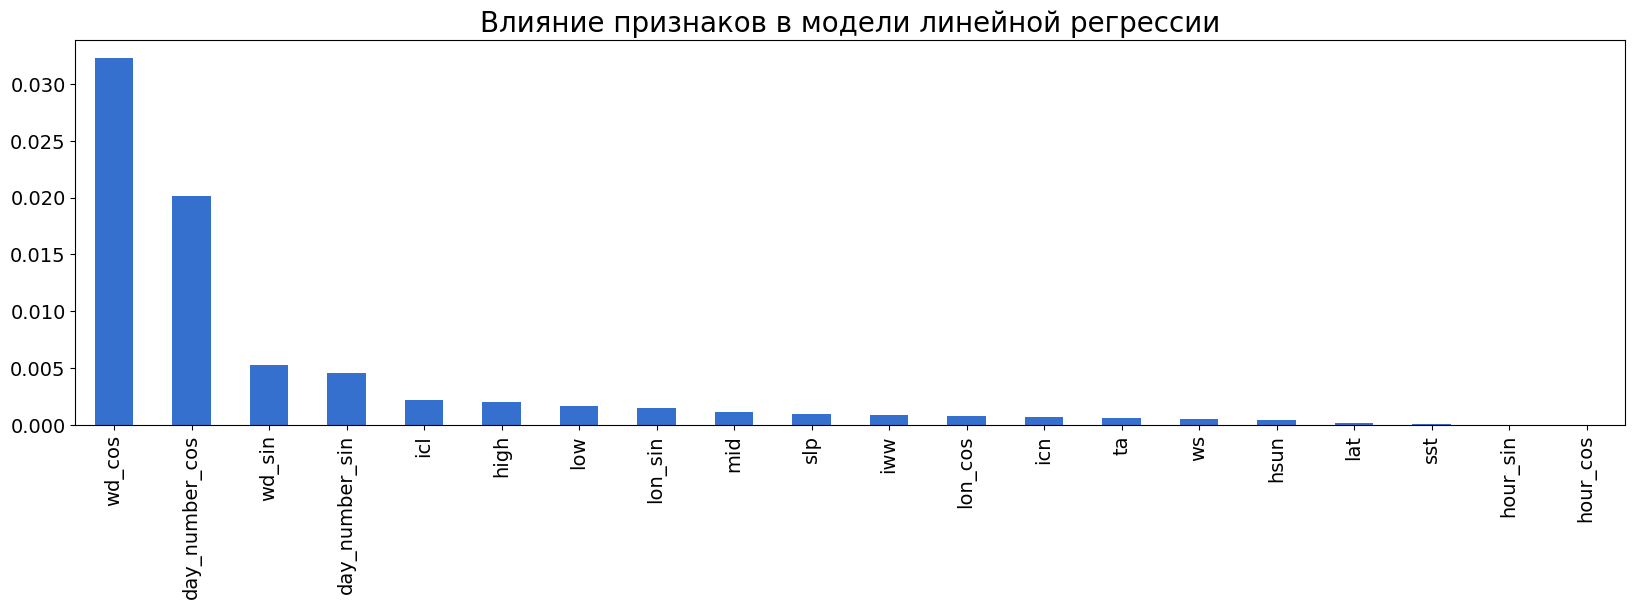

In [ ]:
importance = pd.Series(
    data = np.abs(model.coef_),
    index = x_train.columns)

importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(20,5), fontsize=14, color="#3670CF")
plt.title("Влияние признаков в модели линейной регрессии", fontsize=20)
plt.show()

In [ ]:
feature_importance = model_cat.get_feature_importance()
feature_names = x_train.columns

# Display feature importance
for name, importance in zip(feature_names, feature_importance):
    print(f"Feature: {name}, Importance: {importance:.2f}")

Feature: lat, Importance: 3.30
Feature: hsun, Importance: 8.32
Feature: slp, Importance: 4.46
Feature: ta, Importance: 6.02
Feature: sst, Importance: 1.31
Feature: icn, Importance: 24.21
Feature: icl, Importance: 2.18
Feature: low, Importance: 9.20
Feature: mid, Importance: 0.55
Feature: high, Importance: 0.00
Feature: iww, Importance: 12.10
Feature: ws, Importance: 1.26
Feature: lon_sin, Importance: 0.14
Feature: lon_cos, Importance: 0.10
Feature: day_number_sin, Importance: 1.64
Feature: day_number_cos, Importance: 5.32
Feature: hour_sin, Importance: 0.00
Feature: hour_cos, Importance: 0.00
Feature: wd_sin, Importance: 2.06
Feature: wd_cos, Importance: 17.81


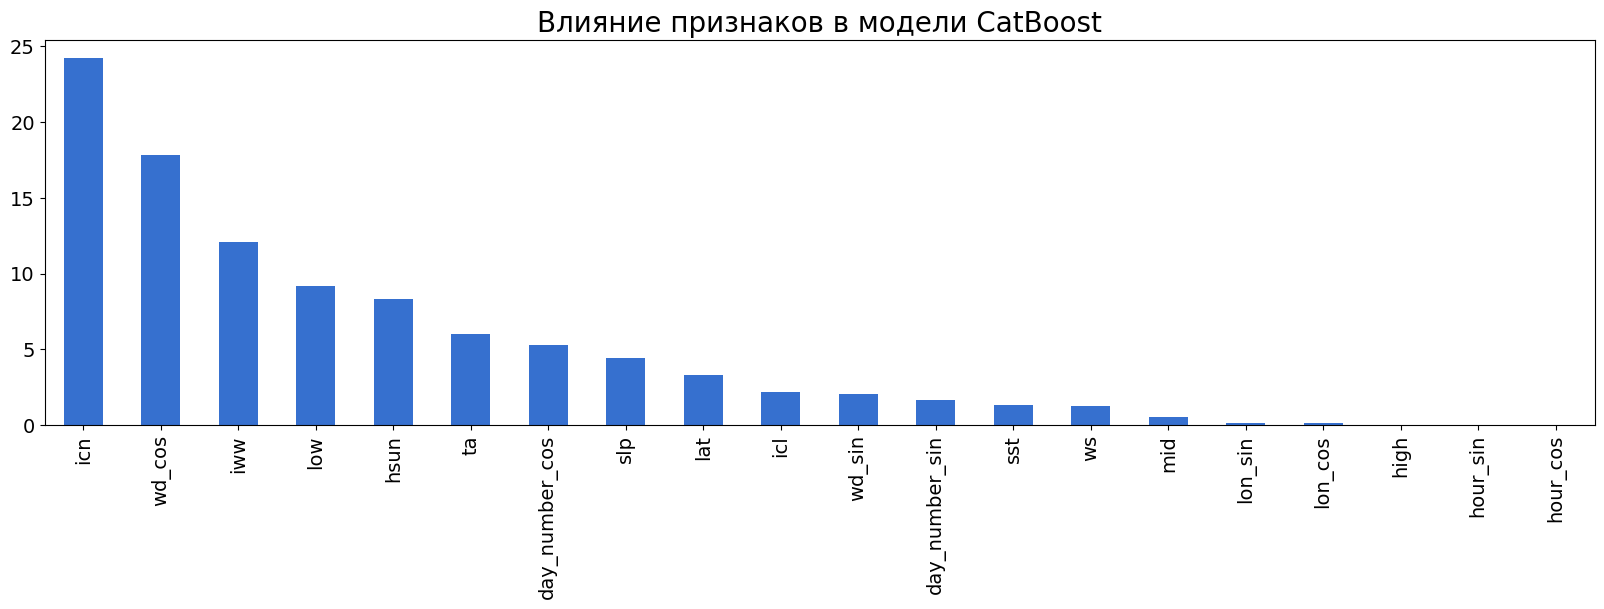

In [ ]:
importance = pd.Series(
    data = feature_importance,
    index = feature_names)

importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(20,5), fontsize=14, color="#3670CF")
plt.title("Влияние признаков в модели CatBoost", fontsize=20)
plt.show()

#### Модель Северной Атлантики — северо-запад

Здесь произведём разбиение датасета на меньшем участке Атлантики и повторим предыдущие шаги для обучения моделей

In [ ]:
df_first_decade_north_atlantic = df_first_decade[
            (df_first_decade["lat"] > 50) &
            (df_first_decade["lat"] < 60) &
            (df_first_decade["lon"] <-10) &
            (df_first_decade["lon"] >-50)]
df_first_decade_north_atlantic

,year,mon,day,hour,lat,lon,hsun,slp,ta,sst,td,rh,icn,icl,low,mid,high,iww,ws,wd
3,1950,1,1,0,59.9,-19.9,-49.36,994.7,7.8,9.4,1.6,0.648,2,-9,-9,-9,-9,-99,17.8,214.0
4,1950,1,1,0,58.7,-16.0,-51.39,1005.2,8.9,9.4,6.7,0.861,7,5,5,7,0,0,15.4,210.0
5,1950,1,1,0,58.2,-21.0,-50.48,1000.6,7.8,7.8,5.6,0.860,4,4,8,0,0,0,15.4,225.0
6,1950,1,1,0,55.0,-13.4,-55.34,1019.0,11.1,10.0,11.1,1.000,8,8,5,-9,-9,0,15.4,203.0
8,1950,1,1,0,54.4,-15.6,-55.29,1014.8,11.1,11.1,10.1,0.936,7,7,5,0,0,8,-9.9,-9.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109247,1960,12,1,0,59.1,-47.4,43.13,979.4,1.1,2.2,-2.2,0.786,8,8,5,-9,-9,2,4.1,240.0
109280,1960,12,1,0,58.8,-18.0,-34.44,987.2,8.2,9.7,4.1,0.753,6,6,8,-9,-9,1,15.9,300.0
109292,1960,12,1,0,53.4,-15.8,-36.65,1002.5,6.8,10.7,5.5,0.914,6,6,2,-9,-9,15,18.0,290.0
109293,1960,12,1,0,53.0,-36.0,-24.54,1001.2,6.1,6.1,1.7,0.734,8,8,-9,-9,-9,-99,17.5,270.0


In [ ]:
df_second_decade_north_atlantic = df_second_decade[
            (df_second_decade["lat"] > 50) &
            (df_second_decade["lat"] < 60) &
            (df_second_decade["lon"] <-10) &
            (df_second_decade["lon"] >-50)]
df_second_decade_north_atlantic

,year,mon,day,hour,lat,lon,hsun,slp,ta,sst,td,rh,icn,icl,low,mid,high,iww,ws,wd
2,1961,1,1,0,58.7,-17.8,-50.94,988.5,7.9,9.7,4.7,0.802,2,2,2,0,0,1,11.8,280.0
11,1961,1,1,0,55.7,-30.7,-48.80,989.9,6.7,9.4,3.9,0.823,8,8,7,-9,-9,25,15.4,250.0
24,1961,1,1,0,53.4,-15.9,-56.07,1002.0,7.8,10.7,6.3,0.902,8,3,2,1,-9,15,14.4,270.0
25,1961,1,1,0,53.2,-17.3,-55.80,1004.4,7.2,-99.9,4.4,0.824,7,3,7,2,0,2,15.4,290.0
27,1961,1,1,0,53.0,-36.0,-47.91,1003.6,5.6,6.1,0.0,0.672,8,8,-9,-9,-9,-99,13.4,270.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109162,1962,12,1,0,59.0,-19.0,-33.89,1028.2,6.0,9.6,1.8,0.744,2,2,0,3,0,2,11.8,90.0
109164,1962,12,1,0,55.4,-11.1,-38.90,1015.0,6.1,9.5,-0.8,0.612,7,7,-9,-9,-9,2,19.0,80.0
109173,1962,12,1,0,53.0,-36.0,-24.54,1023.1,6.1,7.8,3.9,0.858,5,4,-9,-9,-9,-99,8.7,23.0
109174,1962,12,1,0,52.8,-35.5,-24.82,1023.1,6.1,7.8,3.9,0.858,5,5,8,0,0,2,8.7,25.0


In [ ]:
names_for_drop = ['icn', 'icl', 'low', 'mid', 'high', 'iww', 'ws', 'wd']
values_for_drop = [-9, -9, -9, -9, -9, -99, -9.9, -9.9]

df_first_decade_replaced = df_first_decade_north_atlantic
df_second_decade_replaced = df_second_decade_north_atlantic

for key, value in zip(names_for_drop, values_for_drop):
  df_first_decade_replaced.loc[:, key] = df_first_decade_replaced[key].replace(value, np.nan)

for key, value in zip(names_for_drop, values_for_drop):
    df_second_decade_replaced.loc[:, key] = df_second_decade_replaced[key].replace(value, np.nan)


filtered_encoded_train = copy(df_first_decade_replaced)

filtered_encoded_train["day_number"] = get_day_number(filtered_encoded_train["mon"], filtered_encoded_train["day"])
filtered_encoded_train.drop(["day", "mon"], axis=1, inplace=True)

filtered_encoded_train = code_cyclic_values(filtered_encoded_train, ["lon", "day_number", "hour", "wd"])

filtered_encoded_test = copy(df_second_decade_replaced)

filtered_encoded_test["day_number"] = get_day_number(filtered_encoded_test["mon"], filtered_encoded_test["day"])
filtered_encoded_test.drop(["day", "mon"], axis=1, inplace=True)

filtered_encoded_test = code_cyclic_values(filtered_encoded_test, ["lon", "day_number", "hour", "wd"])

df_first_decade_replaced = filtered_encoded_train.dropna()
df_second_decade_replaced = filtered_encoded_test.dropna()

y_train = df_first_decade_replaced['rh']
x_train = df_first_decade_replaced.drop(['td', 'rh'], axis=1, inplace=False)

y_test = df_second_decade_replaced['rh']
x_test = df_second_decade_replaced.drop(['td', 'rh'], axis=1, inplace=False)

x_test = x_test.drop('year', axis=1, inplace=False)
x_train = x_train.drop('year', axis=1, inplace=False)

In [ ]:
model = LinearRegression().fit(x_train, y_train)

y_pred = model.predict(x_test)

R_2 = r2_score(y_test, y_pred)
RMSE = root_mean_squared_error(y_test, y_pred)

print('R**2 score:', R_2)
print('RMSE:', RMSE)

R**2 score: 0.22075031842681292
RMSE: 0.10064672318554534


#### CatBoost north model

In [ ]:
cat_features = ['iww', 'low', 'mid', 'high']

for value in cat_features:
    x_train[value] = x_train[value].astype(str)
    x_test[value] = x_test[value].astype(str)

In [ ]:
model_cat = CatBoostRegressor(iterations=100,
                          depth=2,
                          learning_rate=1,
                          loss_function='RMSE')

train_pool = Pool(x_train, y_train, cat_features=['iww', 'low', 'mid', 'high'])
test_pool = Pool(x_test, y_test, cat_features=['iww', 'low', 'mid', 'high'])

model_cat.fit(train_pool)
y_pred_cat = model_cat.predict(test_pool)

R_2_catboost = r2_score(y_test, y_pred_cat)
RMSE_catboost = root_mean_squared_error(y_test, y_pred_cat)

print('R**2 catboost score:', R_2_catboost)
print('RMSE catboost:', RMSE_catboost)

0:	learn: 0.1031369	total: 67.7ms	remaining: 6.7s
1:	learn: 0.0981199	total: 140ms	remaining: 6.85s
2:	learn: 0.0963998	total: 213ms	remaining: 6.87s
3:	learn: 0.0954930	total: 263ms	remaining: 6.31s
4:	learn: 0.0949163	total: 318ms	remaining: 6.03s
5:	learn: 0.0944983	total: 367ms	remaining: 5.75s
6:	learn: 0.0941818	total: 419ms	remaining: 5.56s
7:	learn: 0.0938213	total: 481ms	remaining: 5.54s
8:	learn: 0.0935671	total: 533ms	remaining: 5.39s
9:	learn: 0.0933659	total: 586ms	remaining: 5.27s
10:	learn: 0.0930872	total: 636ms	remaining: 5.14s
11:	learn: 0.0929613	total: 685ms	remaining: 5.02s
12:	learn: 0.0926434	total: 733ms	remaining: 4.91s
13:	learn: 0.0924838	total: 786ms	remaining: 4.83s
14:	learn: 0.0922284	total: 837ms	remaining: 4.75s
15:	learn: 0.0921350	total: 886ms	remaining: 4.65s
16:	learn: 0.0919686	total: 937ms	remaining: 4.57s
17:	learn: 0.0918699	total: 991ms	remaining: 4.51s
18:	learn: 0.0917089	total: 1.04s	remaining: 4.45s
19:	learn: 0.0915834	total: 1.09s	remaini